In this notebook, we will use the `Mantid` program to look at some powder INS data and do some simple data analysis.

In [1]:
# We first import Mantid and some other common libraries.
import mantid.simpleapi
import numpy as np
import matplotlib.pyplot as plt

INS datafiles from ISIS are saved in the NeXus `nxs` or `nxspe` formats and can be read using the `mslice` program. It's GUI program which can also be used as a commandline library. We first launch it as a GUI using the code below (it can also be launched from the _Mantid Workbench_ by going to the `Interfaces` menu, under the `Direct` option.

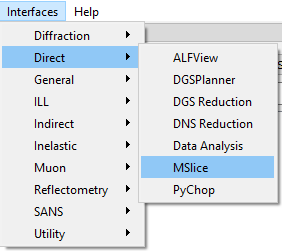

In [2]:
# Runs the MSlice GUI - you must close the GUI before continuing to run this notebook.
# Also note that this will not work on a remotely run notebook (e.g. via a JupyterHub)

import mslice.app

if mslice.app.MAIN_WINDOW is None:
    import mslice.app.mainwindow
    from qtpy.QtWidgets import QLabel
    from qtpy import QT_VERSION
    from mslice.util.qt.qapp import create_qapp_if_required
    def alt_init(self):
        #self.setup_ipython()  # Causes conflict with Jupyter kernel
        self.busy_text = QLabel()
        self.statusBar().addPermanentWidget(self.busy_text)
        self.busy_text.setText("  Idle  ")
        self.busy_text.setStyleSheet("QLabel { color: black }")
        self.busy = False
    # Monkey-patch the init function to not setup IPython
    mslice.app.mainwindow.MainWindow.init_ui = alt_init
    # Now initialise a QApplication
    qapp_ref = create_qapp_if_required()
    import matplotlib as mpl
    mpl.use('Qt{}Agg'.format(QT_VERSION[0]))
    mslice.app.MAIN_WINDOW = mslice.app.mainwindow.MainWindow(in_mantid=True)

mslice.app.main()

0

Note that the MSlice GUI is not really designed to be run in a Notebook so that you must close all MSlice windows before you can continue to run cells in the notebook.

Next we use MSlice as a commandline library to load some data files and display them.

First we load data for Aluminium, which shows phonon scattering.

In [3]:
# Set the plots to be in-line from now on
%matplotlib inline

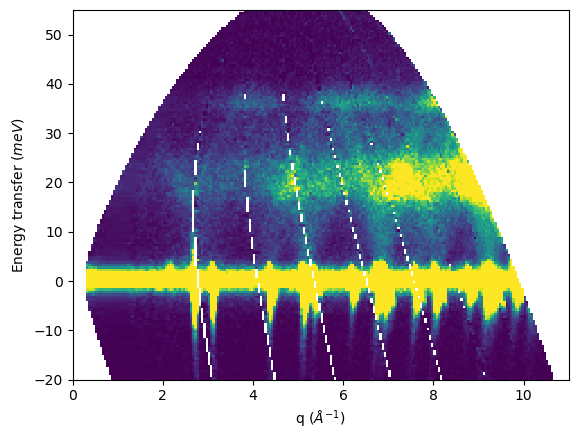

In [4]:
# Imports MSlice as a CLI program
import mslice.cli as mc
import mslice.plotting.pyplot as mplt

import os
data_folder = os.path.join(os.getcwd(), '..', 'datafiles')
# You may need to rename this to some actual directory where the data are.
# The above code assumes you downloaded the zip of the course materials and did not change the path of this notebook.
#data_folder = r'c:\some\path\to\the\datafiles'

# Loads the data and make a 2D slice
ws_aluminium_Ei60 = mc.Load(Filename=f'{data_folder}/aluminium_Ei60.nxspe', OutputWorkspace='aluminium_Ei60')
slice_ws = mc.Slice(ws_aluminium_Ei60, Axis1="|Q|, 0, 11, 0.05", Axis2="DeltaE,-20.0, 55, 0.5", NormToOne=False)

# The following code will plot using the GUI giving an interactive plot window.
#fig = mplt.gcf()
#fig.clf()
#ax = fig.add_subplot(111, projection="mslice")
#mesh = ax.pcolormesh(slice_ws, cmap="viridis")
#mesh.set_clim(0.0, 1.0)
#cb = plt.colorbar(mesh, ax=ax)
#cb.set_label('Intensity (arb. units)')
#ax.set_title('aluminium_Ei60')
#mc.Show()

# This code will instead plot (a non-interactive graph) inline within the notebook
ax = plt.subplot(111, projection='mantid')
ax.pcolormesh(mc.Transpose(slice_ws).raw_ws, cmap='viridis', vmax=1)

We now make a DOS cut by integrating the data in $|Q|$ from 6 to 11 Å$^{-1}$ and plot it.

The data was measured at base temperature (10 K) and we will ignore the Debye-Waller factor (by setting the mean squared displacement to zero).

You can compare the plot below to a reference measurement (e.g. https://journals.aps.org/prb/abstract/10.1103/PhysRevB.77.024301).

What do you think the feature at low energy is?

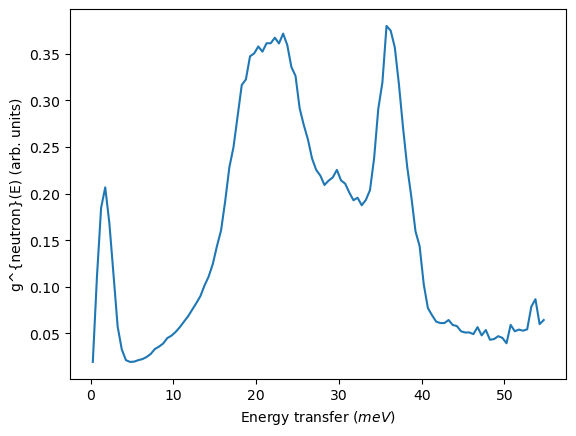

In [5]:
ws_dos = mantid.simpleapi.ComputeIncoherentDOS(mc.Slice(ws_aluminium_Ei60).raw_ws, 
        Temperature=10, MeanSquareDisplacement=0,
        QSumRange='6,11', EnergyBinning='0,0.5,55', StoreInADS=False)
ax = plt.subplot(111, projection='mantid')
ax.plot(ws_dos)

We're now going to load some magnetic data - in this case a crystal field (CEF) measurement on Er$_2$Ir$_2$O$_7$.

We will then calculate the magnetic form factor for Er$^{3+}$ and overplot it over a $Q$-cut of one CEF excitations.

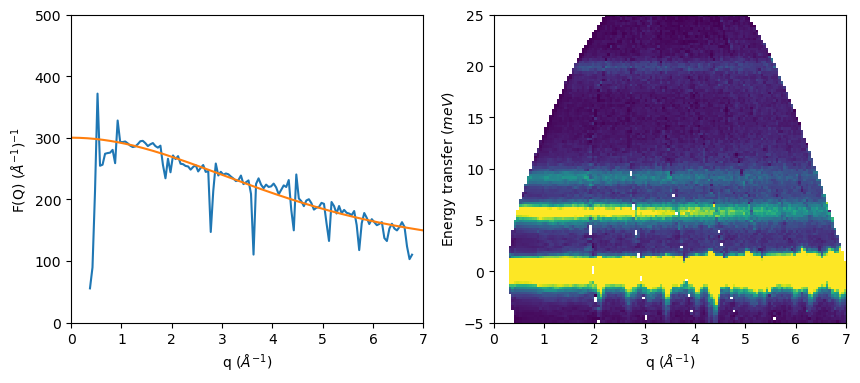

In [6]:
from mantid.simpleapi import mtd, MagFormFactorCorrection

# Loads the data and make a 2D slice
ws_er2ir2o7_Ei30_5K = mc.Load(Filename=f'{data_folder}/er2ir2o7_Ei30_5K.nxspe', OutputWorkspace='er2ir2o7_Ei30_5K')
slice_ws = mc.Slice(ws_er2ir2o7_Ei30_5K, Axis1="|Q|, 0, 7, 0.05", Axis2="DeltaE,-5, 25, 0.25", NormToOne=False)

# Make 1D slice
cut_ws = mc.Cut(ws_er2ir2o7_Ei30_5K, CutAxis='|Q|, 0, 7, 0.05', IntegrationAxis='DeltaE, 3.5, 7.5')

# Calculate the form factor for Er3+
ion = 'Er3'
ws_corr = MagFormFactorCorrection(slice_ws.raw_ws, IonName=ion, FormFactorWorkspace='FFCalc')
ws_fsquare = mtd['FFCalc'] * mtd['FFCalc']

# We rescale (to peak intensity of 180) the calculated form factor to match the data and add a background (120)
ws_fsq_scaled = ws_fsquare * 180 + 120

# Now plot everything
fg, axes = plt.subplots(1, 2, subplot_kw={'projection':'mantid'}, figsize=(10,4))
axes[0].plot(cut_ws.raw_ws)
axes[0].set(xlim=(0,7), ylim=(0,500))
axes[0].plot(ws_fsq_scaled)
axes[1].pcolormesh(mc.Transpose(slice_ws).raw_ws, cmap='viridis', vmin=0, vmax=500)